# Part 1: What Does Pruning Look Like? A Visual Introduction

Welcome to this hands-on demonstration of neural network pruning!

Before we apply pruning to a full neural network, let's build a simple intuition. At its core, pruning is about identifying and removing "less important" weights in a network. We often do this by **zeroing out** the weights.

In this section, we will visualize what this process looks like on a single, randomly generated 2D tensor (which you can think of as a single weight matrix in a neural network layer). We will explore two main types of pruning:

1.  **Unstructured Pruning:** Removing individual weights based on their magnitude (value).
2.  **Structured Pruning:** Removing entire groups of weights (like columns or rows) based on a shared importance score.

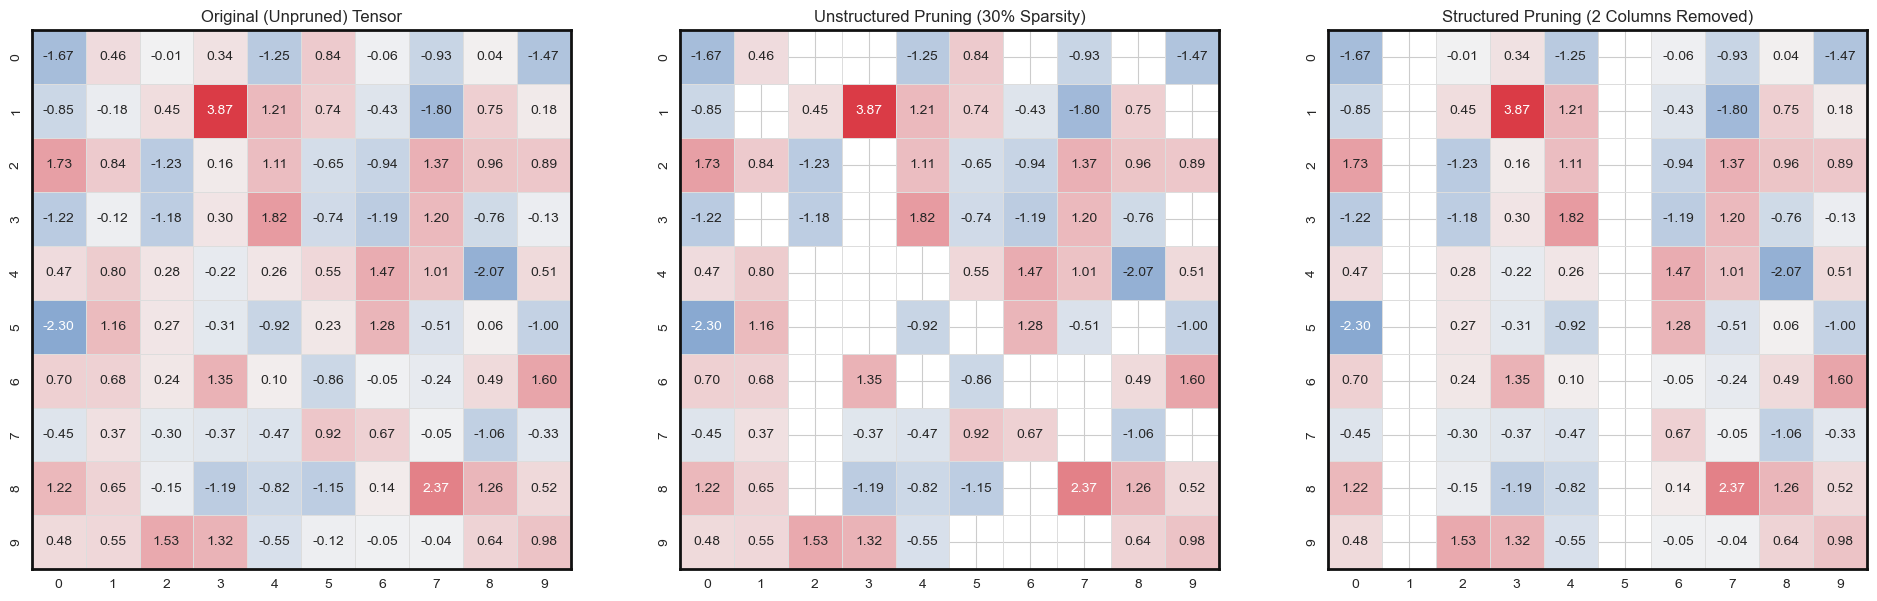

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

# --- 1. Create Original Tensor ---
tensor = torch.randn(10, 10)

# --- 2. Create Unstructured Pruned Tensor ---
unstructured_pruned_tensor = tensor.clone()

# Find the 30% of weights with the lowest absolute values
k_unstructured = int(0.3 * unstructured_pruned_tensor.numel())
threshold = torch.kthvalue(unstructured_pruned_tensor.abs().view(-1), k_unstructured).values
# Zero out the weights below the threshold
unstructured_pruned_tensor[unstructured_pruned_tensor.abs() < threshold] = 0

# --- 3. Create Structured Pruned Tensor ---
structured_pruned_tensor = tensor.clone()
# Calculate the L2-norm of each column
column_norms = torch.norm(structured_pruned_tensor, p=2, dim=0)
# Find the indices of the 2 columns with the lowest norms
k_structured = 2
prune_indices = torch.topk(column_norms, k_structured, largest=False).indices
# Zero out the entire columns
structured_pruned_tensor[:, prune_indices] = 0

# --- 4. Visualize all three tensors side-by-side ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.15)  # control spacing between subplots
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Use a consistent color scale across all plots for fair comparison
max_val = torch.stack([
    tensor.abs().max(),
    unstructured_pruned_tensor.abs().max(),
    structured_pruned_tensor.abs().max()
]).max().item()
vmin, vmax = -max_val, max_val

# Common heatmap kwargs
heatmap_kwargs = dict(cmap=cmap, fmt='.2f', cbar=False, square=True,
                      linewidths=0.6, linecolor='#DDDDDD', center=0,
                      vmin=vmin, vmax=vmax)

# Plot 1: Original Tensor
sns.heatmap(tensor.numpy(), annot=True, ax=axes[0], **heatmap_kwargs)
axes[0].set_title("Original (Unpruned) Tensor")

# Plot 2: Unstructured Pruning (mask zeros)
mask_un = (unstructured_pruned_tensor.numpy() == 0)
sns.heatmap(unstructured_pruned_tensor.numpy(), annot=True, mask=mask_un, ax=axes[1], **heatmap_kwargs)
axes[1].set_title("Unstructured Pruning (30% Sparsity)")

# Plot 3: Structured Pruning (mask zeros)
mask_st = (structured_pruned_tensor.numpy() == 0)
sns.heatmap(structured_pruned_tensor.numpy(), annot=True, mask=mask_st, ax=axes[2], **heatmap_kwargs)
axes[2].set_title("Structured Pruning (2 Columns Removed)")

# Add a clear border (spines) around each subplot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2.0)
        spine.set_edgecolor("#111111")

plt.show()

### Unstructured vs. Structured Pruning

The visualization above shows the key difference between the two main types of pruning:

*   **Unstructured Pruning (Middle):** Individual weights are zeroed out based on their low magnitude. This creates a sparse pattern. It is very flexible but may require special hardware or libraries to accelerate.

*   **Structured Pruning (Right):** Entire groups of weights (in this case, two whole columns) are removed. This is more rigid but can lead to direct speedups on standard hardware because it preserves the dense matrix structure.

# Part 2: Preparing a Model for Pruning

Now that we have a visual intuition, let's apply these concepts to a real neural network. We will perform the following steps:

1.  Define a Model: We'll use the classic LeNet architecture, a simple but effective Convolutional Neural Network (CNN).
2.  Load Data: We'll use the standard MNIST dataset of handwritten digits.
3.  Train a Baseline: We'll train the model from scratch to establish a baseline accuracy. This baseline is the target we'll try to match with our pruned models after fine-tuning.

In [2]:
# Import all necessary libraries for training
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optional: speed up on CuDNN backends (safe for fixed input sizes like MNIST))
try:
    if device.type == "cuda":
        import torch.backends.cudnn as cudnn
        cudnn.benchmark = True
except Exception:
    pass

# Training and evaluation helpers only (keep the demo focused on pruning)

def train(model, train_loader, optimizer, criterion, epochs=3):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / max(1, len(train_loader)):.4f}")


def evaluate(model, test_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

Using device: cuda


In [3]:
# Define the LeNet model architecture
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 256)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset
import torch  # ensure torch is available in this cell for pin_memory
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

pin_mem = torch.cuda.is_available()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=pin_mem, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, pin_memory=pin_mem, num_workers=2)

In [4]:
# Instantiate and train the baseline model
baseline_model = LeNet()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("--- Training Baseline Model ---")
train(baseline_model, train_loader, optimizer, criterion, epochs=3)

print("\n--- Evaluating Baseline Model ---")
baseline_accuracy = evaluate(baseline_model, test_loader)

--- Training Baseline Model ---
Epoch 1/3, Loss: 0.2298
Epoch 2/3, Loss: 0.0710
Epoch 3/3, Loss: 0.0527

--- Evaluating Baseline Model ---
Accuracy: 98.67%


# Part 3: One-Shot Pruning: Unstructured vs. Structured

Now we will apply the two pruning techniques to our trained `LeNet` model. This approach is called **"one-shot" pruning** because we apply it all at once after initial training.

We will perform the following steps for both unstructured and structured pruning:
1.  **Prune:** Apply a pruning function from `torch.nn.utils.prune` to remove 40% of the weights in the convolutional and fully-connected layers.
2.  **Evaluate Accuracy Drop:** Test the model immediately after pruning to see the negative impact on accuracy.
3.  **Fine-Tune:** Re-train the pruned model for a few epochs to help it recover its accuracy.
4.  **Final Evaluation:** Test the fine-tuned model to see how close its accuracy is to the original baseline.

In [5]:
# --- 1. One-Shot Unstructured Pruning ---

# Create a new model instance to prune
unstructured_pruned_model = LeNet()
unstructured_pruned_model.load_state_dict(baseline_model.state_dict())

# Define which layers and parameters to prune
parameters_to_prune = (
    (unstructured_pruned_model.conv1, 'weight'),
    (unstructured_pruned_model.conv2, 'weight'),
    (unstructured_pruned_model.fc1, 'weight'),
    (unstructured_pruned_model.fc2, 'weight'),
    (unstructured_pruned_model.fc3, 'weight'),
)

# Apply L1 unstructured pruning
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.4,  # Prune 40% of the weights globally
)

print("--- Evaluating Unstructured Pruned Model (Before Fine-Tuning) ---")
evaluate(unstructured_pruned_model, test_loader)

# Fine-tune the pruned model
optimizer = optim.Adam(unstructured_pruned_model.parameters(), lr=0.0005) # Lower learning rate for fine-tuning
print("\n--- Fine-Tuning Unstructured Pruned Model ---")
train(unstructured_pruned_model, train_loader, optimizer, criterion, epochs=2)

print("\n--- Evaluating Unstructured Pruned Model (After Fine-Tuning) ---")
unstructured_accuracy = evaluate(unstructured_pruned_model, test_loader)

# Check sparsity (pruning concept)
total_params = 0
zero_params = 0
for name, module in unstructured_pruned_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        total_params += float(module.weight.nelement())
        zero_params += float(torch.sum(module.weight == 0))

print(f"\nGlobal Sparsity: {100. * zero_params / total_params:.2f}%")

--- Evaluating Unstructured Pruned Model (Before Fine-Tuning) ---
Accuracy: 98.61%

--- Fine-Tuning Unstructured Pruned Model ---
Epoch 1/2, Loss: 0.0326
Epoch 2/2, Loss: 0.0263

--- Evaluating Unstructured Pruned Model (After Fine-Tuning) ---
Accuracy: 98.82%

Global Sparsity: 40.00%


In [6]:
# --- 2. One-Shot Structured Pruning ---

# Create another model instance for structured pruning
structured_pruned_model = LeNet()
structured_pruned_model.load_state_dict(baseline_model.state_dict())

# Apply L2-norm structured pruning to convolutional layers
# We will prune 2 out of 6 filters in conv1 and 6 out of 16 in conv2 (~40%)
prune.ln_structured(structured_pruned_model.conv1, name="weight", amount=2, n=2, dim=0)
prune.ln_structured(structured_pruned_model.conv2, name="weight", amount=6, n=2, dim=0)

print("--- Evaluating Structured Pruned Model (Before Fine-Tuning) ---")
evaluate(structured_pruned_model, test_loader)

# Fine-tune the pruned model
optimizer = optim.Adam(structured_pruned_model.parameters(), lr=0.0005)
print("\n--- Fine-Tuning Structured Pruned Model ---")
train(structured_pruned_model, train_loader, optimizer, criterion, epochs=2)

print("\n--- Evaluating Structured Pruned Model (After Fine-Tuning) ---")
structured_accuracy = evaluate(structured_pruned_model, test_loader)

--- Evaluating Structured Pruned Model (Before Fine-Tuning) ---
Accuracy: 94.77%

--- Fine-Tuning Structured Pruned Model ---
Epoch 1/2, Loss: 0.0468
Epoch 2/2, Loss: 0.0355

--- Evaluating Structured Pruned Model (After Fine-Tuning) ---
Accuracy: 98.75%


### Quick Comparison

Let's compare the results:

*   **Baseline Accuracy:** `{{baseline_accuracy:.2f}}%`
*   **Unstructured Pruned Accuracy:** `{{unstructured_accuracy:.2f}}%`
*   **Structured Pruned Accuracy:** `{{structured_accuracy:.2f}}%`

Both methods recovered accuracy very well after fine-tuning. Unstructured pruning often maintains slightly higher accuracy because it has more freedom to choose which individual weights to remove. However, structured pruning can be more beneficial for actual hardware acceleration.

# Part 4: Iterative Pruning

As we mentioned in the presentation, one-shot pruning can be suboptimal, especially when you want to achieve very high levels of sparsity. A more effective method is **Iterative Pruning**:

1.  **Prune** a small percentage of weights.
2.  **Fine-tune** the model for a few epochs to recover accuracy.
3.  **Repeat** this process until the desired sparsity is reached.

This allows the model to gradually adapt to the removal of weights, often resulting in better performance at the same level of sparsity compared to one-shot pruning.

In [7]:
# Create a new model for iterative pruning
iterative_pruned_model = LeNet()
iterative_pruned_model.load_state_dict(baseline_model.state_dict())

# Parameters for iterative pruning
iterations = 5
prune_rate = 0.2 # Prune 20% of the *remaining* weights each iteration
accuracies = []
sparsities = []

# The same parameters we pruned before
parameters_to_prune_iter = (
    (iterative_pruned_model.conv1, 'weight'),
    (iterative_pruned_model.conv2, 'weight'),
    (iterative_pruned_model.fc1, 'weight'),
    (iterative_pruned_model.fc2, 'weight'),
    (iterative_pruned_model.fc3, 'weight'),
)

print("--- Starting Iterative Pruning ---")

for i in range(iterations):
    print(f"\n--- Iteration {i+1}/{iterations} ---")
    
    # Prune the model
    prune.global_unstructured(
        parameters_to_prune_iter,
        pruning_method=prune.L1Unstructured,
        amount=prune_rate,
    )
    
    # Fine-tune
    optimizer = optim.Adam(iterative_pruned_model.parameters(), lr=0.0005)
    train(iterative_pruned_model, train_loader, optimizer, criterion, epochs=1)
    
    # Evaluate and store results
    acc = evaluate(iterative_pruned_model, test_loader)
    accuracies.append(acc)
    
    # Calculate and store sparsity
    total_params = 0
    zero_params = 0
    for name, module in iterative_pruned_model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_params += float(module.weight.nelement())
            zero_params += float(torch.sum(module.weight == 0))
    
    sparsity = 100. * zero_params / total_params
    sparsities.append(sparsity)
    print(f"Global Sparsity: {sparsity:.2f}%")

--- Starting Iterative Pruning ---

--- Iteration 1/5 ---
Epoch 1/1, Loss: 0.0332
Accuracy: 98.85%
Global Sparsity: 20.00%

--- Iteration 2/5 ---
Epoch 1/1, Loss: 0.0258
Accuracy: 98.92%
Global Sparsity: 36.00%

--- Iteration 3/5 ---
Epoch 1/1, Loss: 0.0208
Accuracy: 98.97%
Global Sparsity: 48.80%

--- Iteration 4/5 ---
Epoch 1/1, Loss: 0.0179
Accuracy: 99.11%
Global Sparsity: 59.04%

--- Iteration 5/5 ---
Epoch 1/1, Loss: 0.0161
Accuracy: 99.03%
Global Sparsity: 67.23%


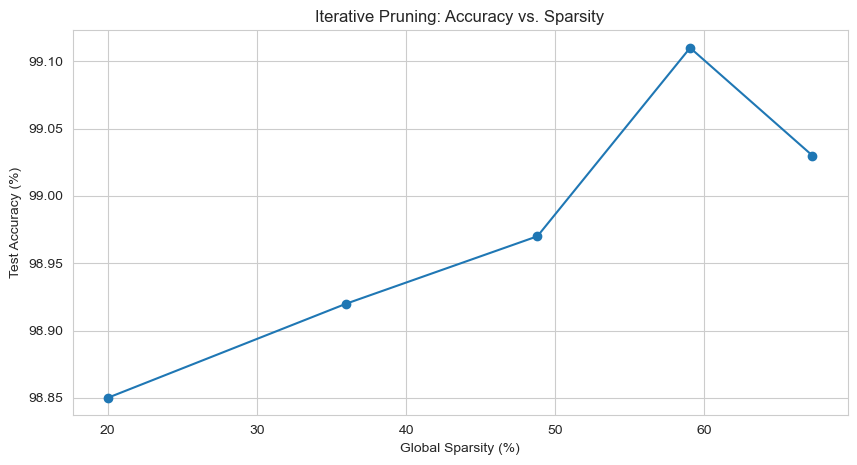

In [8]:
# Plot the results of iterative pruning
plt.figure(figsize=(10, 5))
plt.plot(sparsities, accuracies, marker='o')
plt.title("Iterative Pruning: Accuracy vs. Sparsity")
plt.xlabel("Global Sparsity (%)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.show()

# Part 5: Finalizing the Model & Conclusion

The pruning we've applied so far uses re-parameterization (adding masks to weights). To commit the changes permanently, we remove the pruning re-parameterization so that the zeroed weights become part of the model parameters.

In practice, this means calling `prune.remove(...)` on the pruned parameters. After this step, there are no pruning hooks; the pruned weights remain zero and the model behaves the same during inference.

In [9]:
# Make the pruning permanent on the iteratively pruned model
for module, param_name in parameters_to_prune_iter:
    prune.remove(module, param_name)

print("--- Final Evaluation After Making Pruning Permanent ---")
final_accuracy = evaluate(iterative_pruned_model, test_loader)

--- Final Evaluation After Making Pruning Permanent ---
Accuracy: 99.03%


## Conclusion & Next Steps

In this notebook, we have:
1.  **Visualized** the difference between unstructured and structured pruning.
2.  **Trained** a baseline CNN model and established its performance and size.
3.  **Applied** one-shot pruning and seen how fine-tuning is essential to recover accuracy.
4.  **Implemented** iterative pruning to achieve high sparsity while maintaining high accuracy.

This hands-on process demonstrates the core concepts of pruning and provides a practical foundation for understanding more advanced topics mentioned in the seminar.